In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

4


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

# cv

In [9]:
from sklearn.linear_model import Ridge

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=['weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0', 'const_one', 'visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean', 'genre_name_visitors_mean', 'day_of_week_visitors_mean', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'visitor_ma2', 'visitor_ma4', 'visitor_ma7', 'visitor_ma14', 'visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 'visitor_sma2', 'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16', 'visitor_sma32', 'visitors_minus_ma28', 'visitors_divid_ma28', 'all_count_y1', 'geo1_count_y1', 'station_count_y1', 'geo2_count_y1', 'all_count_y2', 'geo1_count_y2', 'station_count_y2', 'geo2_count_y2', 'all_count_y3', 'geo1_count_y3', 'station_count_y3', 'geo2_count_y3', 'all_count_y4', 'geo1_count_y4', 'station_count_y4', 'geo2_count_y4', 'all_count_y5', 'geo1_count_y5', 'station_count_y5', 'geo2_count_y5', 'TMAX', 'TMIN', 'TAVG', 'PRCP', 'holiday', 's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio', 'f_t', 'bad_ratio', 'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean']
len(lag_cols)

72

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        gbm = Ridge()
        gbm.fit(trainX,trainy)

        models.append(gbm)
        validpred=gbm.predict(validX)
        scores.append(mean_squared_error(validy,validpred))
        print mean_squared_error(trainy,gbm.predict(trainX)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        X=np.concatenate([X,np.isnan(X)],1)
        X[np.isnan(X)]=0        
        pred=model.predict(X).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
EXCLUDE_HARD=True
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('3000eb_ridge_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (161815, 2) (42138, 2)


rand split across time
train has 161815 records out of 389630 records
valid has 42138 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1264
0


(161815, 1, 18) (161815, 7, 72) (161815, 1) (161815, 1)
(161815, 522) (161815,) (161815,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(5803, 1, 18) (5803, 7, 72) (5803, 1) (5803, 1)
(5803, 522) (5803,) (5803,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.06315234394e-11 / 5.96046447754e-08
  RuntimeWarning)


0.0956936 0.260963
[0.26096329]
-1 mean score 0.260963


0.239191


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.969901 -0.040791  0.270795    7  2017-04-16
472     2.507290  2.583651 -0.076360  0.266704    1  2017-04-17
473     2.661330  2.660485  0.000845  0.284841    2  2017-04-18
474     2.754815  2.767256 -0.012441  0.230574    3  2017-04-19
475     2.713762  2.753264 -0.039502  0.253637    4  2017-04-20
476     2.999000  2.994135  0.004864  0.164835    5  2017-04-21
477     3.075529  3.110437 -0.034908  0.202953    6  2017-04-22

0.239191


pred         y     error    error2  day        date
dayidx                                                         
471     2.969901  2.929110 -0.040791  0.270795    7  2017-04-16
472     2.583651  2.507290 -0.076360  0.266704    1  2017-04-17
473     2.660485  2.661330  0.000845  0.284841    2  2017-04-18
474     2.767256  2.754815 -0.012441  0.230574    3  2017-04-19
475     2.753264  2.713762 -0.039502  0.253637    4  2017-04-20
476     2.994135  2.999000  0.004864  0.164835    5  2017-04-21
477     3.110437  3.075529 -0.034908  0.202953    6  2017-04-22

(829, 1044)




2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (167097, 2) (43491, 2)


rand split across time
train has 167097 records out of 389630 records
valid has 43491 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1305
0


(167097, 1, 18) (167097, 7, 72) (167097, 1) (167097, 1)
(167097, 522) (167097,) (167097,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(6632, 1, 18) (6632, 7, 72) (6632, 1) (6632, 1)
(6632, 522) (6632,) (6632,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.99160268411e-11 / 5.96046447754e-08
  RuntimeWarning)


0.0981668 0.255347
[0.2553471]
-1 mean score 0.255347
0.239332


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.950149 -0.021039  0.270476    7  2017-04-16
472     2.507290  2.585876 -0.078585  0.264988    1  2017-04-17
473     2.661330  2.678545 -0.017215  0.283719    2  2017-04-18
474     2.754815  2.771915 -0.017100  0.233583    3  2017-04-19
475     2.713762  2.760215 -0.046453  0.254711    4  2017-04-20
476     2.999000  3.009689 -0.010690  0.168375    5  2017-04-21
477     3.075529  3.084156 -0.008627  0.199469    6  2017-04-22

0.239332


pred         y     error    error2  day        date
dayidx                                                         
471     2.950149  2.929110 -0.021039  0.270476    7  2017-04-16
472     2.585876  2.507290 -0.078585  0.264988    1  2017-04-17
473     2.678545  2.661330 -0.017215  0.283719    2  2017-04-18
474     2.771915  2.754815 -0.017100  0.233583    3  2017-04-19
475     2.760215  2.713762 -0.046453  0.254711    4  2017-04-20
476     3.009689  2.999000 -0.010690  0.168375    5  2017-04-21
477     3.084156  3.075529 -0.008627  0.199469    6  2017-04-22

(829, 1044)




3


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (167606, 2) (43564, 2)


rand split across time
train has 167606 records out of 389630 records
valid has 43564 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1309
0


(167606, 1, 18) (167606, 7, 72) (167606, 1) (167606, 1)
(167606, 522) (167606,) (167606,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(7461, 1, 18) (7461, 7, 72) (7461, 1) (7461, 1)
(7461, 522) (7461,) (7461,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.25716892294e-11 / 5.96046447754e-08
  RuntimeWarning)


0.0995681 0.26176
[0.26175955]
-1 mean score 0.26176
0.240661


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.946112 -0.017002  0.270339    7  2017-04-16
472     2.507290  2.589906 -0.082616  0.266026    1  2017-04-17
473     2.661330  2.671228 -0.009898  0.286031    2  2017-04-18
474     2.754815  2.778012 -0.023197  0.234316    3  2017-04-19
475     2.713762  2.761899 -0.048138  0.258226    4  2017-04-20
476     2.999000  3.006164 -0.007164  0.169828    5  2017-04-21
477     3.075529  3.095314 -0.019785  0.199862    6  2017-04-22

0.240661


pred         y     error    error2  day        date
dayidx                                                         
471     2.946112  2.929110 -0.017002  0.270339    7  2017-04-16
472     2.589906  2.507290 -0.082616  0.266026    1  2017-04-17
473     2.671228  2.661330 -0.009898  0.286031    2  2017-04-18
474     2.778012  2.754815 -0.023197  0.234316    3  2017-04-19
475     2.761899  2.713762 -0.048138  0.258226    4  2017-04-20
476     3.006164  2.999000 -0.007164  0.169828    5  2017-04-21
477     3.095314  3.075529 -0.019785  0.199862    6  2017-04-22

(829, 1044)




4


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (167719, 2) (43576, 2)


rand split across time
train has 167719 records out of 389630 records
valid has 43576 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1310
0


(167719, 1, 18) (167719, 7, 72) (167719, 1) (167719, 1)
(167719, 522) (167719,) (167719,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(8290, 1, 18) (8290, 7, 72) (8290, 1) (8290, 1)
(8290, 522) (8290,) (8290,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.02164172955e-10 / 5.96046447754e-08
  RuntimeWarning)


0.100757 0.26127
[0.26126987]
-1 mean score 0.26127
0.241695


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.936332 -0.007223  0.270432    7  2017-04-16
472     2.507290  2.601267 -0.093977  0.268474    1  2017-04-17
473     2.661330  2.653804  0.007526  0.286486    2  2017-04-18
474     2.754815  2.767243 -0.012428  0.233177    3  2017-04-19
475     2.713762  2.757423 -0.043661  0.261905    4  2017-04-20
476     2.999000  2.979648  0.019351  0.172173    5  2017-04-21
477     3.075529  3.095636 -0.020106  0.199216    6  2017-04-22

0.241695


pred         y     error    error2  day        date
dayidx                                                         
471     2.936332  2.929110 -0.007223  0.270432    7  2017-04-16
472     2.601267  2.507290 -0.093977  0.268474    1  2017-04-17
473     2.653804  2.661330  0.007526  0.286486    2  2017-04-18
474     2.767243  2.754815 -0.012428  0.233177    3  2017-04-19
475     2.757423  2.713762 -0.043661  0.261905    4  2017-04-20
476     2.979648  2.999000  0.019351  0.172173    5  2017-04-21
477     3.095636  3.075529 -0.020106  0.199216    6  2017-04-22

(829, 1044)




5


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (167837, 2) (43655, 2)


rand split across time
train has 167837 records out of 389630 records
valid has 43655 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1311
0


(167837, 1, 18) (167837, 7, 72) (167837, 1) (167837, 1)
(167837, 522) (167837,) (167837,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(9119, 1, 18) (9119, 7, 72) (9119, 1) (9119, 1)
(9119, 522) (9119,) (9119,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.14856309028e-11 / 5.96046447754e-08
  RuntimeWarning)


0.101372 0.25987
[0.25986955]
-1 mean score 0.25987
0.242252


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.953849 -0.024739  0.272094    7  2017-04-16
472     2.507290  2.596488 -0.089198  0.268267    1  2017-04-17
473     2.661330  2.661678 -0.000349  0.287059    2  2017-04-18
474     2.754815  2.755272 -0.000457  0.233869    3  2017-04-19
475     2.713762  2.749614 -0.035853  0.261071    4  2017-04-20
476     2.999000  2.985432  0.013567  0.172598    5  2017-04-21
477     3.075529  3.079785 -0.004256  0.200806    6  2017-04-22

0.242252


pred         y     error    error2  day        date
dayidx                                                         
471     2.953849  2.929110 -0.024739  0.272094    7  2017-04-16
472     2.596488  2.507290 -0.089198  0.268267    1  2017-04-17
473     2.661678  2.661330 -0.000349  0.287059    2  2017-04-18
474     2.755272  2.754815 -0.000457  0.233869    3  2017-04-19
475     2.749614  2.713762 -0.035853  0.261071    4  2017-04-20
476     2.985432  2.999000  0.013567  0.172598    5  2017-04-21
477     3.079785  3.075529 -0.004256  0.200806    6  2017-04-22

(829, 1044)




6


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 15.1334


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (167810, 2) (43607, 2)


rand split across time
train has 167810 records out of 389630 records
valid has 43607 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1311
0


(167810, 1, 18) (167810, 7, 72) (167810, 1) (167810, 1)


(167810, 522) (167810,) (167810,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(9948, 1, 18) (9948, 7, 72) (9948, 1) (9948, 1)
(9948, 522) (9948,) (9948,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.57563987499e-11 / 5.96046447754e-08
  RuntimeWarning)


0.102165 0.263175
[0.26317516]
-1 mean score 0.263175
0.243498


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.952130 -0.023020  0.272130    7  2017-04-16
472     2.507290  2.602152 -0.094861  0.270619    1  2017-04-17
473     2.661330  2.655879  0.005451  0.289185    2  2017-04-18
474     2.754815  2.756422 -0.001607  0.233712    3  2017-04-19
475     2.713762  2.746178 -0.032417  0.261364    4  2017-04-20
476     2.999000  2.966912  0.032088  0.174811    5  2017-04-21
477     3.075529  3.091111 -0.015582  0.202667    6  2017-04-22

0.243498


pred         y     error    error2  day        date
dayidx                                                         
471     2.952130  2.929110 -0.023020  0.272130    7  2017-04-16
472     2.602152  2.507290 -0.094861  0.270619    1  2017-04-17
473     2.655879  2.661330  0.005451  0.289185    2  2017-04-18
474     2.756421  2.754815 -0.001607  0.233712    3  2017-04-19
475     2.746178  2.713762 -0.032417  0.261364    4  2017-04-20
476     2.966912  2.999000  0.032088  0.174811    5  2017-04-21
477     3.091111  3.075529 -0.015582  0.202667    6  2017-04-22

(829, 1044)




7


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 16.3101


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (168179, 2) (43706, 2)


rand split across time
train has 168179 records out of 389630 records
valid has 43706 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1313
0


(168179, 1, 18) (168179, 7, 72) (168179, 1) (168179, 1)


(168179, 522) (168179,) (168179,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(10777, 1, 18) (10777, 7, 72) (10777, 1) (10777, 1)
(10777, 522) (10777,) (10777,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.37669586473e-11 / 5.96046447754e-08
  RuntimeWarning)


0.103194 0.26009
[0.2600897]
-1 mean score 0.26009
0.244423


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.951881 -0.022771  0.270686    7  2017-04-16
472     2.507290  2.617995 -0.110705  0.277777    1  2017-04-17
473     2.661330  2.668661 -0.007331  0.293292    2  2017-04-18
474     2.754815  2.745732  0.009083  0.237272    3  2017-04-19
475     2.713762  2.746888 -0.033127  0.261054    4  2017-04-20
476     2.999000  2.980311  0.018689  0.172852    5  2017-04-21
477     3.075529  3.100756 -0.025227  0.198026    6  2017-04-22

0.244423


pred         y     error    error2  day        date
dayidx                                                         
471     2.951881  2.929110 -0.022771  0.270686    7  2017-04-16
472     2.617995  2.507290 -0.110705  0.277777    1  2017-04-17
473     2.668661  2.661330 -0.007331  0.293292    2  2017-04-18
474     2.745732  2.754815  0.009083  0.237272    3  2017-04-19
475     2.746888  2.713762 -0.033127  0.261054    4  2017-04-20
476     2.980311  2.999000  0.018689  0.172852    5  2017-04-21
477     3.100756  3.075529 -0.025227  0.198026    6  2017-04-22

(829, 1044)




8


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 17.5743


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (167604, 2) (43529, 2)


rand split across time
train has 167604 records out of 389630 records
valid has 43529 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1309
0


(167604, 1, 18) (167604, 7, 72) (167604, 1) (167604, 1)


(167604, 522) (167604,) (167604,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(11606, 1, 18) (11606, 7, 72) (11606, 1) (11606, 1)
(11606, 522) (11606,) (11606,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.43877469503e-11 / 5.96046447754e-08
  RuntimeWarning)


0.111783 0.258976
[0.25897571]
-1 mean score 0.258976
0.252592


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.971832 -0.042722  0.284432    7  2017-04-16
472     2.507290  2.622545 -0.115255  0.279447    1  2017-04-17
473     2.661330  2.692787 -0.031457  0.299159    2  2017-04-18
474     2.754815  2.763238 -0.008423  0.252366    3  2017-04-19
475     2.713762  2.746961 -0.033200  0.268545    4  2017-04-20
476     2.999000  2.998894  0.000106  0.182462    5  2017-04-21
477     3.075529  3.111379 -0.035850  0.201733    6  2017-04-22

0.252592


pred         y     error    error2  day        date
dayidx                                                         
471     2.971832  2.929110 -0.042722  0.284432    7  2017-04-16
472     2.622545  2.507290 -0.115255  0.279447    1  2017-04-17
473     2.692787  2.661330 -0.031457  0.299159    2  2017-04-18
474     2.763238  2.754815 -0.008423  0.252366    3  2017-04-19
475     2.746961  2.713762 -0.033200  0.268545    4  2017-04-20
476     2.998894  2.999000  0.000106  0.182462    5  2017-04-21
477     3.111379  3.075529 -0.035850  0.201733    6  2017-04-22

(829, 1044)




9


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 18.8065


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (168556, 2) (43819, 2)


rand split across time
train has 168556 records out of 389630 records
valid has 43819 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1316
0


(168556, 1, 18) (168556, 7, 72) (168556, 1) (168556, 1)


(168556, 522) (168556,) (168556,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(12435, 1, 18) (12435, 7, 72) (12435, 1) (12435, 1)
(12435, 522) (12435,) (12435,)


0.112886 0.265627
[0.26562664]
-1 mean score 0.265627
0.252481


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.967241 -0.038131  0.282758    7  2017-04-16
472     2.507290  2.624571 -0.117280  0.279349    1  2017-04-17
473     2.661330  2.704589 -0.043259  0.304859    2  2017-04-18
474     2.754815  2.766996 -0.012181  0.250757    3  2017-04-19
475     2.713762  2.754118 -0.040357  0.268320    4  2017-04-20
476     2.999000  2.986974  0.012026  0.181340    5  2017-04-21
477     3.075529  3.105529 -0.030000  0.199986    6  2017-04-22

0.252481


pred         y     error    error2  day        date
dayidx                                                         
471     2.967241  2.929110 -0.038131  0.282758    7  2017-04-16
472     2.624571  2.507290 -0.117280  0.279349    1  2017-04-17
473     2.704589  2.661330 -0.043259  0.304859    2  2017-04-18
474     2.766996  2.754815 -0.012181  0.250757    3  2017-04-19
475     2.754118  2.713762 -0.040357  0.268320    4  2017-04-20
476     2.986974  2.999000  0.012026  0.181340    5  2017-04-21
477     3.105529  3.075529 -0.030000  0.199986    6  2017-04-22

(829, 1044)




10


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 19.9265


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (168701, 2) (43810, 2)


rand split across time
train has 168701 records out of 389630 records
valid has 43810 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1317
0


(168701, 1, 18) (168701, 7, 72) (168701, 1) (168701, 1)


(168701, 522) (168701,) (168701,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(13264, 1, 18) (13264, 7, 72) (13264, 1) (13264, 1)
(13264, 522) (13264,) (13264,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.81050782005e-11 / 5.96046447754e-08
  RuntimeWarning)


0.113351 0.271024
[0.2710239]
-1 mean score 0.271024
0.253051


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.967064 -0.037954  0.284398    7  2017-04-16
472     2.507290  2.629409 -0.122119  0.278508    1  2017-04-17
473     2.661330  2.702022 -0.040693  0.306063    2  2017-04-18
474     2.754815  2.760272 -0.005457  0.253107    3  2017-04-19
475     2.713762  2.754761 -0.041000  0.270052    4  2017-04-20
476     2.999000  3.000330 -0.001331  0.180756    5  2017-04-21
477     3.075529  3.086151 -0.010622  0.198474    6  2017-04-22

0.253051


pred         y     error    error2  day        date
dayidx                                                         
471     2.967064  2.929110 -0.037954  0.284398    7  2017-04-16
472     2.629409  2.507290 -0.122119  0.278508    1  2017-04-17
473     2.702022  2.661330 -0.040693  0.306063    2  2017-04-18
474     2.760272  2.754815 -0.005457  0.253107    3  2017-04-19
475     2.754761  2.713762 -0.041000  0.270052    4  2017-04-20
476     3.000330  2.999000 -0.001331  0.180756    5  2017-04-21
477     3.086151  3.075529 -0.010622  0.198474    6  2017-04-22

(829, 1044)




11


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 21.0577


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (168655, 2) (43810, 2)


rand split across time
train has 168655 records out of 389630 records
valid has 43810 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1317
0


(168655, 1, 18) (168655, 7, 72) (168655, 1) (168655, 1)


(168655, 522) (168655,) (168655,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(14093, 1, 18) (14093, 7, 72) (14093, 1) (14093, 1)
(14093, 522) (14093,) (14093,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.00124863797e-11 / 5.96046447754e-08
  RuntimeWarning)


0.113831 0.271623
[0.27162251]
-1 mean score 0.271623
0.252572


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.958013 -0.028903  0.283273    7  2017-04-16
472     2.507290  2.638549 -0.131259  0.281387    1  2017-04-17
473     2.661330  2.712787 -0.051457  0.305830    2  2017-04-18
474     2.754815  2.746263  0.008552  0.250541    3  2017-04-19
475     2.713762  2.746214 -0.032453  0.269010    4  2017-04-20
476     2.999000  3.004154 -0.005154  0.178127    5  2017-04-21
477     3.075529  3.099705 -0.024176  0.199836    6  2017-04-22

0.252572


pred         y     error    error2  day        date
dayidx                                                         
471     2.958013  2.929110 -0.028903  0.283273    7  2017-04-16
472     2.638549  2.507290 -0.131259  0.281387    1  2017-04-17
473     2.712787  2.661330 -0.051457  0.305830    2  2017-04-18
474     2.746263  2.754815  0.008552  0.250541    3  2017-04-19
475     2.746214  2.713762 -0.032453  0.269010    4  2017-04-20
476     3.004154  2.999000 -0.005154  0.178127    5  2017-04-21
477     3.099705  3.075529 -0.024176  0.199836    6  2017-04-22

(829, 1044)




12


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 22.1151


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (168667, 2) (43819, 2)


rand split across time
train has 168667 records out of 389630 records
valid has 43819 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1317
0


(168667, 1, 18) (168667, 7, 72) (168667, 1) (168667, 1)


(168667, 522) (168667,) (168667,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(14922, 1, 18) (14922, 7, 72) (14922, 1) (14922, 1)
(14922, 522) (14922,) (14922,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.64225585855e-11 / 5.96046447754e-08
  RuntimeWarning)


0.113782 0.270837
[0.27083671]
-1 mean score 0.270837
0.254073


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.972002 -0.042892  0.284596    7  2017-04-16
472     2.507290  2.644513 -0.137223  0.282490    1  2017-04-17
473     2.661330  2.719727 -0.058397  0.305231    2  2017-04-18
474     2.754815  2.757335 -0.002520  0.254079    3  2017-04-19
475     2.713762  2.736273 -0.022512  0.270170    4  2017-04-20
476     2.999000  2.994172  0.004828  0.180735    5  2017-04-21
477     3.075529  3.106025 -0.030496  0.201214    6  2017-04-22

0.254073


pred         y     error    error2  day        date
dayidx                                                         
471     2.972002  2.929110 -0.042892  0.284596    7  2017-04-16
472     2.644513  2.507290 -0.137223  0.282490    1  2017-04-17
473     2.719727  2.661330 -0.058397  0.305231    2  2017-04-18
474     2.757335  2.754815 -0.002520  0.254079    3  2017-04-19
475     2.736273  2.713762 -0.022512  0.270170    4  2017-04-20
476     2.994172  2.999000  0.004828  0.180735    5  2017-04-21
477     3.106025  3.075529 -0.030496  0.201214    6  2017-04-22

(829, 1044)




13


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 23.1552


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (168601, 2) (43808, 2)


rand split across time
train has 168601 records out of 389630 records
valid has 43808 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1317
0


(168601, 1, 18) (168601, 7, 72) (168601, 1) (168601, 1)


(168601, 522) (168601,) (168601,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(15751, 1, 18) (15751, 7, 72) (15751, 1) (15751, 1)
(15751, 522) (15751,) (15751,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.87619511541e-11 / 5.96046447754e-08
  RuntimeWarning)


0.114054 0.27199
[0.27198979]
-1 mean score 0.27199
0.25483


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.965251 -0.036141  0.287654    7  2017-04-16
472     2.507290  2.659144 -0.151854  0.287098    1  2017-04-17
473     2.661330  2.716409 -0.055079  0.305349    2  2017-04-18
474     2.754815  2.761038 -0.006224  0.253171    3  2017-04-19
475     2.713762  2.747981 -0.034220  0.270199    4  2017-04-20
476     2.999000  3.000827 -0.001827  0.179438    5  2017-04-21
477     3.075529  3.095372 -0.019843  0.200903    6  2017-04-22

0.25483


pred         y     error    error2  day        date
dayidx                                                         
471     2.965251  2.929110 -0.036141  0.287654    7  2017-04-16
472     2.659144  2.507290 -0.151854  0.287098    1  2017-04-17
473     2.716409  2.661330 -0.055079  0.305349    2  2017-04-18
474     2.761038  2.754815 -0.006224  0.253171    3  2017-04-19
475     2.747981  2.713762 -0.034220  0.270199    4  2017-04-20
476     3.000827  2.999000 -0.001827  0.179438    5  2017-04-21
477     3.095372  3.075529 -0.019843  0.200903    6  2017-04-22

(829, 1044)




14


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 24.2264


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (168860, 2) (43858, 2)


rand split across time
train has 168860 records out of 389630 records
valid has 43858 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1319
0


(168860, 1, 18) (168860, 7, 72) (168860, 1) (168860, 1)


(168860, 522) (168860,) (168860,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(16580, 1, 18) (16580, 7, 72) (16580, 1) (16580, 1)
(16580, 522) (16580,) (16580,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.55538827546e-11 / 5.96046447754e-08
  RuntimeWarning)


0.113569 0.267671
[0.26767057]
-1 mean score 0.267671
0.256722


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.967121 -0.038011  0.288093    7  2017-04-16
472     2.507290  2.650652 -0.143361  0.290071    1  2017-04-17
473     2.661330  2.725121 -0.063792  0.308588    2  2017-04-18
474     2.754815  2.754966 -0.000152  0.257420    3  2017-04-19
475     2.713762  2.744874 -0.031112  0.270486    4  2017-04-20
476     2.999000  3.013136 -0.014136  0.178353    5  2017-04-21
477     3.075529  3.095857 -0.020328  0.204045    6  2017-04-22

0.256722


pred         y     error    error2  day        date
dayidx                                                         
471     2.967121  2.929110 -0.038011  0.288093    7  2017-04-16
472     2.650652  2.507290 -0.143361  0.290071    1  2017-04-17
473     2.725121  2.661330 -0.063792  0.308588    2  2017-04-18
474     2.754966  2.754815 -0.000152  0.257420    3  2017-04-19
475     2.744874  2.713762 -0.031112  0.270486    4  2017-04-20
476     3.013136  2.999000 -0.014136  0.178353    5  2017-04-21
477     3.095857  3.075529 -0.020328  0.204045    6  2017-04-22

(829, 1044)




15


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 25.3577


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (168303, 2) (43699, 2)


rand split across time
train has 168303 records out of 389630 records
valid has 43699 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1314
0


(168303, 1, 18) (168303, 7, 72) (168303, 1) (168303, 1)
(168303, 522) (168303,) (168303,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(17409, 1, 18) (17409, 7, 72) (17409, 1) (17409, 1)
(17409, 522) (17409,) (17409,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.72210760877e-11 / 5.96046447754e-08
  RuntimeWarning)


0.118419 0.264277
[0.2642765]
-1 mean score 0.264277
0.263882


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  3.004861 -0.075751  0.310845    7  2017-04-16
472     2.507290  2.654115 -0.146825  0.296909    1  2017-04-17
473     2.661330  2.740951 -0.079621  0.318699    2  2017-04-18
474     2.754815  2.754441  0.000373  0.253249    3  2017-04-19
475     2.713762  2.743255 -0.029494  0.280771    4  2017-04-20
476     2.999000  3.003119 -0.004120  0.182139    5  2017-04-21
477     3.075529  3.091801 -0.016272  0.204560    6  2017-04-22

0.263882


pred         y     error    error2  day        date
dayidx                                                         
471     3.004861  2.929110 -0.075751  0.310845    7  2017-04-16
472     2.654115  2.507290 -0.146825  0.296909    1  2017-04-17
473     2.740951  2.661330 -0.079621  0.318699    2  2017-04-18
474     2.754441  2.754815  0.000373  0.253249    3  2017-04-19
475     2.743255  2.713762 -0.029494  0.280771    4  2017-04-20
476     3.003119  2.999000 -0.004120  0.182139    5  2017-04-21
477     3.091801  3.075529 -0.016272  0.204560    6  2017-04-22

(829, 1044)




16


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 26.4659


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (169097, 2) (43979, 2)


rand split across time
train has 169097 records out of 389630 records
valid has 43979 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1321
0


(169097, 1, 18) (169097, 7, 72) (169097, 1) (169097, 1)


(169097, 522) (169097,) (169097,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(18238, 1, 18) (18238, 7, 72) (18238, 1) (18238, 1)
(18238, 522) (18238,) (18238,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.25194080534e-12 / 5.96046447754e-08
  RuntimeWarning)


0.119998 0.270869
[0.27086914]
-1 mean score 0.270869
0.265636


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.982897 -0.053787  0.303840    7  2017-04-16
472     2.507290  2.666073 -0.158782  0.304030    1  2017-04-17
473     2.661330  2.735974 -0.074644  0.319998    2  2017-04-18
474     2.754815  2.760635 -0.005820  0.257910    3  2017-04-19
475     2.713762  2.757579 -0.043817  0.281966    4  2017-04-20
476     2.999000  2.991238  0.007762  0.185715    5  2017-04-21
477     3.075529  3.090247 -0.014718  0.205989    6  2017-04-22

0.265636


pred         y     error    error2  day        date
dayidx                                                         
471     2.982897  2.929110 -0.053787  0.303840    7  2017-04-16
472     2.666073  2.507290 -0.158782  0.304030    1  2017-04-17
473     2.735974  2.661330 -0.074644  0.319998    2  2017-04-18
474     2.760635  2.754815 -0.005820  0.257910    3  2017-04-19
475     2.757579  2.713762 -0.043817  0.281966    4  2017-04-20
476     2.991238  2.999000  0.007762  0.185715    5  2017-04-21
477     3.090247  3.075529 -0.014718  0.205989    6  2017-04-22

(829, 1044)




17


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 27.6058


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (169468, 2) (43957, 2)


rand split across time
train has 169468 records out of 389630 records
valid has 43957 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1323
0


(169468, 1, 18) (169468, 7, 72) (169468, 1) (169468, 1)
(169468, 522) (169468,) (169468,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(19067, 1, 18) (19067, 7, 72) (19067, 1) (19067, 1)
(19067, 522) (19067,) (19067,)


0.120298 0.277272
[0.27727199]
-1 mean score 0.277272
0.265258


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.969638 -0.040528  0.300826    7  2017-04-16
472     2.507290  2.641031 -0.133740  0.297036    1  2017-04-17
473     2.661330  2.731886 -0.070557  0.320362    2  2017-04-18
474     2.754815  2.772570 -0.017755  0.259653    3  2017-04-19
475     2.713762  2.758703 -0.044942  0.285716    4  2017-04-20
476     2.999000  3.004905 -0.005906  0.186780    5  2017-04-21
477     3.075529  3.079946 -0.004417  0.206430    6  2017-04-22

0.265258


pred         y     error    error2  day        date
dayidx                                                         
471     2.969638  2.929110 -0.040528  0.300826    7  2017-04-16
472     2.641031  2.507290 -0.133740  0.297036    1  2017-04-17
473     2.731886  2.661330 -0.070557  0.320362    2  2017-04-18
474     2.772570  2.754815 -0.017755  0.259653    3  2017-04-19
475     2.758703  2.713762 -0.044942  0.285716    4  2017-04-20
476     3.004905  2.999000 -0.005906  0.186780    5  2017-04-21
477     3.079946  3.075529 -0.004417  0.206430    6  2017-04-22

(829, 1044)




18


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 28.7513


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (169407, 2) (43964, 2)


rand split across time
train has 169407 records out of 389630 records
valid has 43964 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1323
0


(169407, 1, 18) (169407, 7, 72) (169407, 1) (169407, 1)
(169407, 522) (169407,) (169407,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(19896, 1, 18) (19896, 7, 72) (19896, 1) (19896, 1)
(19896, 522) (19896,) (19896,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.17462357685e-11 / 5.96046447754e-08
  RuntimeWarning)


0.120561 0.27691
[0.27691019]
-1 mean score 0.27691
0.265525


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.981275 -0.052165  0.304048    7  2017-04-16
472     2.507290  2.639262 -0.131971  0.296084    1  2017-04-17
473     2.661330  2.723631 -0.062301  0.319058    2  2017-04-18
474     2.754815  2.759574 -0.004760  0.260852    3  2017-04-19
475     2.713762  2.752119 -0.038357  0.283662    4  2017-04-20
476     2.999000  3.008269 -0.009269  0.188607    5  2017-04-21
477     3.075529  3.081952 -0.006423  0.206362    6  2017-04-22

0.265525


pred         y     error    error2  day        date
dayidx                                                         
471     2.981275  2.929110 -0.052165  0.304048    7  2017-04-16
472     2.639262  2.507290 -0.131971  0.296084    1  2017-04-17
473     2.723631  2.661330 -0.062301  0.319058    2  2017-04-18
474     2.759574  2.754815 -0.004760  0.260852    3  2017-04-19
475     2.752119  2.713762 -0.038357  0.283662    4  2017-04-20
476     3.008269  2.999000 -0.009269  0.188607    5  2017-04-21
477     3.081952  3.075529 -0.006423  0.206362    6  2017-04-22

(829, 1044)




19


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 29.7986


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (169455, 2) (44041, 2)


rand split across time
train has 169455 records out of 389630 records
valid has 44041 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1323
0


(169455, 1, 18) (169455, 7, 72) (169455, 1) (169455, 1)


(169455, 522) (169455,) (169455,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(20725, 1, 18) (20725, 7, 72) (20725, 1) (20725, 1)
(20725, 522) (20725,) (20725,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.69981258372e-12 / 5.96046447754e-08
  RuntimeWarning)


0.120647 0.272983
[0.27298251]
-1 mean score 0.272983
0.266184


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.962922 -0.033812  0.304128    7  2017-04-16
472     2.507290  2.649215 -0.141925  0.296319    1  2017-04-17
473     2.661330  2.719533 -0.058204  0.317841    2  2017-04-18
474     2.754815  2.747931  0.006884  0.259606    3  2017-04-19
475     2.713762  2.771832 -0.058070  0.286312    4  2017-04-20
476     2.999000  3.016262 -0.017262  0.190543    5  2017-04-21
477     3.075529  3.096364 -0.020834  0.208537    6  2017-04-22

0.266184


pred         y     error    error2  day        date
dayidx                                                         
471     2.962922  2.929110 -0.033812  0.304128    7  2017-04-16
472     2.649215  2.507290 -0.141925  0.296319    1  2017-04-17
473     2.719534  2.661330 -0.058204  0.317841    2  2017-04-18
474     2.747931  2.754815  0.006884  0.259606    3  2017-04-19
475     2.771832  2.713762 -0.058070  0.286312    4  2017-04-20
476     3.016262  2.999000 -0.017262  0.190543    5  2017-04-21
477     3.096364  3.075529 -0.020834  0.208537    6  2017-04-22

(829, 1044)




20


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 30.7963


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (169278, 2) (43953, 2)


rand split across time
train has 169278 records out of 389630 records
valid has 43953 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1322
0


(169278, 1, 18) (169278, 7, 72) (169278, 1) (169278, 1)


(169278, 522) (169278,) (169278,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(21554, 1, 18) (21554, 7, 72) (21554, 1) (21554, 1)
(21554, 522) (21554,) (21554,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.41955448732e-11 / 5.96046447754e-08
  RuntimeWarning)


0.120216 0.276499
[0.27649906]
-1 mean score 0.276499
0.265903


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.994595 -0.065485  0.309972    7  2017-04-16
472     2.507290  2.621917 -0.114626  0.289533    1  2017-04-17
473     2.661330  2.738650 -0.077320  0.320061    2  2017-04-18
474     2.754815  2.748615  0.006200  0.259194    3  2017-04-19
475     2.713762  2.736880 -0.023118  0.286991    4  2017-04-20
476     2.999000  3.012306 -0.013306  0.188279    5  2017-04-21
477     3.075529  3.090131 -0.014601  0.207289    6  2017-04-22

0.265903


pred         y     error    error2  day        date
dayidx                                                         
471     2.994595  2.929110 -0.065485  0.309972    7  2017-04-16
472     2.621917  2.507290 -0.114626  0.289533    1  2017-04-17
473     2.738650  2.661330 -0.077320  0.320061    2  2017-04-18
474     2.748615  2.754815  0.006200  0.259194    3  2017-04-19
475     2.736880  2.713762 -0.023118  0.286991    4  2017-04-20
476     3.012305  2.999000 -0.013306  0.188279    5  2017-04-21
477     3.090131  3.075529 -0.014601  0.207289    6  2017-04-22

(829, 1044)




21


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 31.7929


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (169648, 2) (43981, 2)


rand split across time
train has 169648 records out of 389630 records
valid has 43981 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1325
0


(169648, 1, 18) (169648, 7, 72) (169648, 1) (169648, 1)
(169648, 522) (169648,) (169648,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(22383, 1, 18) (22383, 7, 72) (22383, 1) (22383, 1)
(22383, 522) (22383,) (22383,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.4305289432e-11 / 5.96046447754e-08
  RuntimeWarning)


0.120227 0.272098
[0.27209765]
-1 mean score 0.272098
0.267033


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.937417 -0.008307  0.303394    7  2017-04-16
472     2.507290  2.630555 -0.123264  0.292693    1  2017-04-17
473     2.661330  2.706936 -0.045606  0.317413    2  2017-04-18
474     2.754815  2.763019 -0.008205  0.262201    3  2017-04-19
475     2.713762  2.722177 -0.008415  0.287854    4  2017-04-20
476     2.999000  2.977511  0.021488  0.192847    5  2017-04-21
477     3.075529  3.113067 -0.037538  0.212829    6  2017-04-22

0.267033


pred         y     error    error2  day        date
dayidx                                                         
471     2.937417  2.929110 -0.008307  0.303393    7  2017-04-16
472     2.630555  2.507290 -0.123264  0.292693    1  2017-04-17
473     2.706936  2.661330 -0.045606  0.317413    2  2017-04-18
474     2.763019  2.754815 -0.008205  0.262201    3  2017-04-19
475     2.722177  2.713762 -0.008415  0.287854    4  2017-04-20
476     2.977511  2.999000  0.021488  0.192847    5  2017-04-21
477     3.113067  3.075529 -0.037538  0.212829    6  2017-04-22

(829, 1044)




22


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 32.871


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (169065, 2) (43856, 2)


rand split across time
train has 169065 records out of 389630 records
valid has 43856 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1320
0


(169065, 1, 18) (169065, 7, 72) (169065, 1) (169065, 1)


(169065, 522) (169065,) (169065,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(23212, 1, 18) (23212, 7, 72) (23212, 1) (23212, 1)
(23212, 522) (23212,) (23212,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.11435946077e-12 / 5.96046447754e-08
  RuntimeWarning)


0.125122 0.269923
[0.26992267]
-1 mean score 0.269923
0.267439


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.946882 -0.017772  0.303007    7  2017-04-16
472     2.507290  2.574378 -0.067088  0.291546    1  2017-04-17
473     2.661330  2.700050 -0.038720  0.316196    2  2017-04-18
474     2.754815  2.744818  0.009997  0.263686    3  2017-04-19
475     2.713762  2.734220 -0.020458  0.292766    4  2017-04-20
476     2.999000  2.970204  0.028796  0.194935    5  2017-04-21
477     3.075529  3.090517 -0.014988  0.209935    6  2017-04-22

0.267439


pred         y     error    error2  day        date
dayidx                                                         
471     2.946882  2.929110 -0.017772  0.303007    7  2017-04-16
472     2.574378  2.507290 -0.067088  0.291546    1  2017-04-17
473     2.700050  2.661330 -0.038720  0.316196    2  2017-04-18
474     2.744818  2.754815  0.009997  0.263686    3  2017-04-19
475     2.734220  2.713762 -0.020458  0.292766    4  2017-04-20
476     2.970204  2.999000  0.028796  0.194935    5  2017-04-21
477     3.090517  3.075529 -0.014988  0.209935    6  2017-04-22

(829, 1044)




23


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 33.9745


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (169915, 2) (44129, 2)


rand split across time
train has 169915 records out of 389630 records
valid has 44129 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1327
0


(169915, 1, 18) (169915, 7, 72) (169915, 1) (169915, 1)


(169915, 522) (169915,) (169915,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(24041, 1, 18) (24041, 7, 72) (24041, 1) (24041, 1)
(24041, 522) (24041,) (24041,)


0.126066 0.27653
[0.27653027]
-1 mean score 0.27653
0.264892


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.951726 -0.022616  0.297471    7  2017-04-16
472     2.507290  2.533579 -0.026288  0.287296    1  2017-04-17
473     2.661330  2.676238 -0.014908  0.314818    2  2017-04-18
474     2.754815  2.747346  0.007469  0.263641    3  2017-04-19
475     2.713762  2.722293 -0.008532  0.289218    4  2017-04-20
476     2.999000  2.988485  0.010515  0.194721    5  2017-04-21
477     3.075529  3.082812 -0.007283  0.207084    6  2017-04-22

0.264892


pred         y     error    error2  day        date
dayidx                                                         
471     2.951726  2.929110 -0.022616  0.297471    7  2017-04-16
472     2.533579  2.507290 -0.026288  0.287296    1  2017-04-17
473     2.676238  2.661330 -0.014908  0.314818    2  2017-04-18
474     2.747346  2.754815  0.007469  0.263641    3  2017-04-19
475     2.722293  2.713762 -0.008532  0.289218    4  2017-04-20
476     2.988485  2.999000  0.010515  0.194721    5  2017-04-21
477     3.082812  3.075529 -0.007283  0.207084    6  2017-04-22

(829, 1044)




24


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 35.2084


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (170158, 2) (44166, 2)


rand split across time
train has 170158 records out of 389630 records
valid has 44166 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1329
0


(170158, 1, 18) (170158, 7, 72) (170158, 1) (170158, 1)


(170158, 522) (170158,) (170158,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(24870, 1, 18) (24870, 7, 72) (24870, 1) (24870, 1)
(24870, 522) (24870,) (24870,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.80799220681e-11 / 5.96046447754e-08
  RuntimeWarning)


0.126898 0.280736
[0.28073576]
-1 mean score 0.280736
0.264145


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.943968 -0.014858  0.293444    7  2017-04-16
472     2.507290  2.557044 -0.049754  0.285240    1  2017-04-17
473     2.661330  2.637130  0.024200  0.314294    2  2017-04-18
474     2.754815  2.726743  0.028072  0.263762    3  2017-04-19
475     2.713762  2.743156 -0.029395  0.291018    4  2017-04-20
476     2.999000  2.969601  0.029398  0.193904    5  2017-04-21
477     3.075529  3.094243 -0.018714  0.207351    6  2017-04-22

0.264145


pred         y     error    error2  day        date
dayidx                                                         
471     2.943968  2.929110 -0.014858  0.293444    7  2017-04-16
472     2.557044  2.507290 -0.049754  0.285240    1  2017-04-17
473     2.637130  2.661330  0.024200  0.314294    2  2017-04-18
474     2.726743  2.754815  0.028072  0.263762    3  2017-04-19
475     2.743156  2.713762 -0.029395  0.291018    4  2017-04-20
476     2.969601  2.999000  0.029398  0.193904    5  2017-04-21
477     3.094243  3.075529 -0.018714  0.207351    6  2017-04-22

(829, 1044)




25


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 36.3351


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (170068, 2) (44171, 2)


rand split across time
train has 170068 records out of 389630 records
valid has 44171 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1328
0


(170068, 1, 18) (170068, 7, 72) (170068, 1) (170068, 1)


(170068, 522) (170068,) (170068,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(25699, 1, 18) (25699, 7, 72) (25699, 1) (25699, 1)
(25699, 522) (25699,) (25699,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.72967853718e-11 / 5.96046447754e-08
  RuntimeWarning)


0.127181 0.280305
[0.28030458]
-1 mean score 0.280305
0.264324


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.928472  0.000638  0.294549    7  2017-04-16
472     2.507290  2.555555 -0.048265  0.286136    1  2017-04-17
473     2.661330  2.663125 -0.001796  0.312890    2  2017-04-18
474     2.754815  2.725968  0.028847  0.264991    3  2017-04-19
475     2.713762  2.681206  0.032556  0.288436    4  2017-04-20
476     2.999000  2.990086  0.008914  0.195008    5  2017-04-21
477     3.075529  3.073996  0.001533  0.208258    6  2017-04-22

0.264324


pred         y     error    error2  day        date
dayidx                                                         
471     2.928472  2.929110  0.000638  0.294549    7  2017-04-16
472     2.555555  2.507290 -0.048265  0.286136    1  2017-04-17
473     2.663125  2.661330 -0.001796  0.312890    2  2017-04-18
474     2.725968  2.754815  0.028847  0.264991    3  2017-04-19
475     2.681206  2.713762  0.032556  0.288436    4  2017-04-20
476     2.990086  2.999000  0.008914  0.195008    5  2017-04-21
477     3.073996  3.075529  0.001533  0.208258    6  2017-04-22

(829, 1044)




26


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 37.3741


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (170126, 2) (44174, 2)


rand split across time
train has 170126 records out of 389630 records
valid has 44174 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1329
0


(170126, 1, 18) (170126, 7, 72) (170126, 1) (170126, 1)


(170126, 522) (170126,) (170126,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(26528, 1, 18) (26528, 7, 72) (26528, 1) (26528, 1)
(26528, 522) (26528,) (26528,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.7877605486e-11 / 5.96046447754e-08
  RuntimeWarning)


0.126884 0.278865
[0.2788648]
-1 mean score 0.278865
0.265814


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924707  0.004403  0.296256    7  2017-04-16
472     2.507290  2.539240 -0.031950  0.285948    1  2017-04-17
473     2.661330  2.666942 -0.005612  0.316064    2  2017-04-18
474     2.754815  2.738763  0.016052  0.264765    3  2017-04-19
475     2.713762  2.667533  0.046229  0.290542    4  2017-04-20
476     2.999000  2.962188  0.036812  0.196230    5  2017-04-21
477     3.075529  3.082994 -0.007464  0.210892    6  2017-04-22

0.265814


pred         y     error    error2  day        date
dayidx                                                         
471     2.924707  2.929110  0.004403  0.296256    7  2017-04-16
472     2.539240  2.507290 -0.031950  0.285948    1  2017-04-17
473     2.666942  2.661330 -0.005612  0.316064    2  2017-04-18
474     2.738763  2.754815  0.016052  0.264765    3  2017-04-19
475     2.667533  2.713762  0.046229  0.290542    4  2017-04-20
476     2.962188  2.999000  0.036812  0.196230    5  2017-04-21
477     3.082994  3.075529 -0.007464  0.210892    6  2017-04-22

(829, 1044)




27


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 38.4506


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (170002, 2) (44134, 2)


rand split across time
train has 170002 records out of 389630 records
valid has 44134 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1328
0


(170002, 1, 18) (170002, 7, 72) (170002, 1) (170002, 1)


(170002, 522) (170002,) (170002,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(27357, 1, 18) (27357, 7, 72) (27357, 1) (27357, 1)
(27357, 522) (27357,) (27357,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.4235325552e-11 / 5.96046447754e-08
  RuntimeWarning)


0.126571 0.279541
[0.2795409]
-1 mean score 0.279541
0.265717


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910511  0.018599  0.296327    7  2017-04-16
472     2.507290  2.545660 -0.038369  0.288736    1  2017-04-17
473     2.661330  2.649898  0.011432  0.318285    2  2017-04-18
474     2.754815  2.737039  0.017776  0.261481    3  2017-04-19
475     2.713762  2.686065  0.027696  0.286310    4  2017-04-20
476     2.999000  2.938994  0.060006  0.197995    5  2017-04-21
477     3.075529  3.058137  0.017393  0.210889    6  2017-04-22

0.265717


pred         y     error    error2  day        date
dayidx                                                         
471     2.910511  2.929110  0.018599  0.296327    7  2017-04-16
472     2.545660  2.507290 -0.038369  0.288736    1  2017-04-17
473     2.649898  2.661330  0.011432  0.318285    2  2017-04-18
474     2.737039  2.754815  0.017776  0.261481    3  2017-04-19
475     2.686065  2.713762  0.027696  0.286310    4  2017-04-20
476     2.938994  2.999000  0.060006  0.197995    5  2017-04-21
477     3.058137  3.075529  0.017393  0.210889    6  2017-04-22

(829, 1044)




28


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 39.4798


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (170270, 2) (44197, 2)


rand split across time
train has 170270 records out of 389630 records
valid has 44197 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1330
0


(170270, 1, 18) (170270, 7, 72) (170270, 1) (170270, 1)
(170270, 522) (170270,) (170270,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(28186, 1, 18) (28186, 7, 72) (28186, 1) (28186, 1)
(28186, 522) (28186,) (28186,)


0.126513 0.275695
[0.27569494]
-1 mean score 0.275695
0.266256


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.929989 -0.000879  0.297518    7  2017-04-16
472     2.507290  2.521454 -0.014163  0.291370    1  2017-04-17
473     2.661330  2.644582  0.016748  0.316725    2  2017-04-18
474     2.754815  2.722197  0.032618  0.265493    3  2017-04-19
475     2.713762  2.685089  0.028673  0.286108    4  2017-04-20
476     2.999000  2.972521  0.026479  0.194369    5  2017-04-21
477     3.075529  3.041253  0.034276  0.212211    6  2017-04-22

0.266256


pred         y     error    error2  day        date
dayidx                                                         
471     2.929989  2.929110 -0.000879  0.297518    7  2017-04-16
472     2.521454  2.507290 -0.014163  0.291370    1  2017-04-17
473     2.644582  2.661330  0.016748  0.316725    2  2017-04-18
474     2.722197  2.754815  0.032618  0.265493    3  2017-04-19
475     2.685089  2.713762  0.028673  0.286108    4  2017-04-20
476     2.972521  2.999000  0.026479  0.194369    5  2017-04-21
477     3.041253  3.075529  0.034276  0.212211    6  2017-04-22

(829, 1044)




29


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 40.7934


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (169709, 2) (44055, 2)


rand split across time
train has 169709 records out of 389630 records
valid has 44055 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1325
0


(169709, 1, 18) (169709, 7, 72) (169709, 1) (169709, 1)


(169709, 522) (169709,) (169709,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(29015, 1, 18) (29015, 7, 72) (29015, 1) (29015, 1)
(29015, 522) (29015,) (29015,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.27290668126e-11 / 5.96046447754e-08
  RuntimeWarning)


0.129059 0.272484
[0.27248439]
-1 mean score 0.272484
0.266227


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.937546 -0.008436  0.300661    7  2017-04-16
472     2.507290  2.557557 -0.050267  0.278819    1  2017-04-17
473     2.661330  2.638158  0.023172  0.320328    2  2017-04-18
474     2.754815  2.738834  0.015981  0.264694    3  2017-04-19
475     2.713762  2.675214  0.038548  0.286218    4  2017-04-20
476     2.999000  2.974255  0.024745  0.198617    5  2017-04-21
477     3.075529  3.051964  0.023565  0.214252    6  2017-04-22

0.266227


pred         y     error    error2  day        date
dayidx                                                         
471     2.937546  2.929110 -0.008436  0.300661    7  2017-04-16
472     2.557557  2.507290 -0.050267  0.278819    1  2017-04-17
473     2.638158  2.661330  0.023172  0.320328    2  2017-04-18
474     2.738834  2.754815  0.015981  0.264694    3  2017-04-19
475     2.675214  2.713762  0.038548  0.286218    4  2017-04-20
476     2.974255  2.999000  0.024745  0.198617    5  2017-04-21
477     3.051964  3.075529  0.023565  0.214252    6  2017-04-22

(829, 1044)




30


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 41.9859


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (170548, 2) (44292, 2)


rand split across time
train has 170548 records out of 389630 records
valid has 44292 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1332
0


(170548, 1, 18) (170548, 7, 72) (170548, 1) (170548, 1)
(170548, 522) (170548,) (170548,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(29844, 1, 18) (29844, 7, 72) (29844, 1) (29844, 1)
(29844, 522) (29844,) (29844,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.16434915665e-11 / 5.96046447754e-08
  RuntimeWarning)


0.130171 0.279614
[0.27961433]
-1 mean score 0.279614
0.26565


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923055  0.006055  0.297667    7  2017-04-16
472     2.507290  2.566682 -0.059392  0.277229    1  2017-04-17
473     2.661330  2.655449  0.005880  0.318995    2  2017-04-18
474     2.754815  2.731446  0.023369  0.266618    3  2017-04-19
475     2.713762  2.689337  0.024425  0.287660    4  2017-04-20
476     2.999000  2.969932  0.029068  0.199425    5  2017-04-21
477     3.075529  3.067173  0.008356  0.211959    6  2017-04-22

0.26565


pred         y     error    error2  day        date
dayidx                                                         
471     2.923055  2.929110  0.006055  0.297667    7  2017-04-16
472     2.566682  2.507290 -0.059392  0.277229    1  2017-04-17
473     2.655449  2.661330  0.005880  0.318995    2  2017-04-18
474     2.731446  2.754815  0.023369  0.266618    3  2017-04-19
475     2.689337  2.713762  0.024425  0.287660    4  2017-04-20
476     2.969932  2.999000  0.029068  0.199425    5  2017-04-21
477     3.067173  3.075529  0.008356  0.211959    6  2017-04-22

(829, 1044)




31


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 43.2281


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (170779, 2) (44347, 2)


rand split across time
train has 170779 records out of 389630 records
valid has 44347 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1334
0


(170779, 1, 18) (170779, 7, 72) (170779, 1) (170779, 1)
(170779, 522) (170779,) (170779,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(30673, 1, 18) (30673, 7, 72) (30673, 1) (30673, 1)
(30673, 522) (30673,) (30673,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.89564977499e-11 / 5.96046447754e-08
  RuntimeWarning)


0.130872 0.283879
[0.28387901]
-1 mean score 0.283879
0.264446


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925365  0.003745  0.296665    7  2017-04-16
472     2.507290  2.561830 -0.054539  0.274772    1  2017-04-17
473     2.661330  2.665489 -0.004159  0.316880    2  2017-04-18
474     2.754815  2.737256  0.017559  0.267997    3  2017-04-19
475     2.713762  2.672664  0.041097  0.284645    4  2017-04-20
476     2.999000  2.982695  0.016305  0.198032    5  2017-04-21
477     3.075529  3.055727  0.019803  0.212131    6  2017-04-22

0.264446


pred         y     error    error2  day        date
dayidx                                                         
471     2.925365  2.929110  0.003745  0.296665    7  2017-04-16
472     2.561830  2.507290 -0.054539  0.274772    1  2017-04-17
473     2.665489  2.661330 -0.004159  0.316880    2  2017-04-18
474     2.737256  2.754815  0.017559  0.267997    3  2017-04-19
475     2.672664  2.713762  0.041097  0.284645    4  2017-04-20
476     2.982695  2.999000  0.016305  0.198032    5  2017-04-21
477     3.055727  3.075529  0.019803  0.212131    6  2017-04-22

(829, 1044)




32


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 44.4464


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (170754, 2) (44321, 2)


rand split across time
train has 170754 records out of 389630 records
valid has 44321 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1334
0


(170754, 1, 18) (170754, 7, 72) (170754, 1) (170754, 1)


(170754, 522) (170754,) (170754,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(31502, 1, 18) (31502, 7, 72) (31502, 1) (31502, 1)
(31502, 522) (31502,) (31502,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.72251759867e-11 / 5.96046447754e-08
  RuntimeWarning)


0.131144 0.285365
[0.28536481]
-1 mean score 0.285365
0.265448


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.934944 -0.005834  0.297385    7  2017-04-16
472     2.507290  2.570498 -0.063208  0.275537    1  2017-04-17
473     2.661330  2.671146 -0.009816  0.317475    2  2017-04-18
474     2.754815  2.737656  0.017158  0.267833    3  2017-04-19
475     2.713762  2.699897  0.013865  0.283179    4  2017-04-20
476     2.999000  2.938403  0.060597  0.204333    5  2017-04-21
477     3.075529  3.051703  0.023826  0.212396    6  2017-04-22

0.265448


pred         y     error    error2  day        date
dayidx                                                         
471     2.934944  2.929110 -0.005834  0.297385    7  2017-04-16
472     2.570498  2.507290 -0.063208  0.275537    1  2017-04-17
473     2.671146  2.661330 -0.009816  0.317475    2  2017-04-18
474     2.737656  2.754815  0.017158  0.267833    3  2017-04-19
475     2.699897  2.713762  0.013865  0.283179    4  2017-04-20
476     2.938403  2.999000  0.060597  0.204333    5  2017-04-21
477     3.051703  3.075529  0.023826  0.212396    6  2017-04-22

(829, 1044)




33


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 45.5115


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (170782, 2) (44349, 2)


rand split across time
train has 170782 records out of 389630 records
valid has 44349 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1334
0


(170782, 1, 18) (170782, 7, 72) (170782, 1) (170782, 1)


(170782, 522) (170782,) (170782,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(32331, 1, 18) (32331, 7, 72) (32331, 1) (32331, 1)
(32331, 522) (32331,) (32331,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.67751870622e-11 / 5.96046447754e-08
  RuntimeWarning)


0.13136 0.284654
[0.28465435]
-1 mean score 0.284654
0.265529


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.936956 -0.007846  0.298971    7  2017-04-16
472     2.507290  2.587142 -0.079851  0.277007    1  2017-04-17
473     2.661330  2.686747 -0.025417  0.316619    2  2017-04-18
474     2.754815  2.736855  0.017960  0.266311    3  2017-04-19
475     2.713762  2.739498 -0.025736  0.284439    4  2017-04-20
476     2.999000  2.944651  0.054349  0.203536    5  2017-04-21
477     3.075529  3.029086  0.046443  0.211822    6  2017-04-22

0.265529


pred         y     error    error2  day        date
dayidx                                                         
471     2.936956  2.929110 -0.007846  0.298971    7  2017-04-16
472     2.587142  2.507290 -0.079851  0.277007    1  2017-04-17
473     2.686747  2.661330 -0.025417  0.316619    2  2017-04-18
474     2.736855  2.754815  0.017960  0.266311    3  2017-04-19
475     2.739498  2.713762 -0.025736  0.284439    4  2017-04-20
476     2.944651  2.999000  0.054349  0.203536    5  2017-04-21
477     3.029086  3.075529  0.046443  0.211822    6  2017-04-22

(829, 1044)




34


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 46.5688


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (170677, 2) (44326, 2)


rand split across time
train has 170677 records out of 389630 records
valid has 44326 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1333
0


(170677, 1, 18) (170677, 7, 72) (170677, 1) (170677, 1)
(170677, 522) (170677,) (170677,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(33160, 1, 18) (33160, 7, 72) (33160, 1) (33160, 1)
(33160, 522) (33160,) (33160,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.21991530661e-11 / 5.96046447754e-08
  RuntimeWarning)


0.130952 0.284462
[0.28446209]
-1 mean score 0.284462
0.266581


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.933897 -0.004787  0.300092    7  2017-04-16
472     2.507290  2.592759 -0.085468  0.278870    1  2017-04-17
473     2.661330  2.704399 -0.043070  0.321958    2  2017-04-18
474     2.754815  2.743118  0.011697  0.266502    3  2017-04-19
475     2.713762  2.731378 -0.017617  0.284025    4  2017-04-20
476     2.999000  2.947033  0.051967  0.203934    5  2017-04-21
477     3.075529  3.063025  0.012504  0.210684    6  2017-04-22

0.266581


pred         y     error    error2  day        date
dayidx                                                         
471     2.933897  2.929110 -0.004787  0.300092    7  2017-04-16
472     2.592759  2.507290 -0.085468  0.278870    1  2017-04-17
473     2.704399  2.661330 -0.043070  0.321958    2  2017-04-18
474     2.743118  2.754815  0.011697  0.266502    3  2017-04-19
475     2.731378  2.713762 -0.017617  0.284025    4  2017-04-20
476     2.947033  2.999000  0.051967  0.203934    5  2017-04-21
477     3.063025  3.075529  0.012504  0.210684    6  2017-04-22

(829, 1044)




35


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 47.4733


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (171048, 2) (44396, 2)


rand split across time
train has 171048 records out of 389630 records
valid has 44396 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1336
0


(171048, 1, 18) (171048, 7, 72) (171048, 1) (171048, 1)
(171048, 522) (171048,) (171048,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(33989, 1, 18) (33989, 7, 72) (33989, 1) (33989, 1)
(33989, 522) (33989,) (33989,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.88759248088e-12 / 5.96046447754e-08
  RuntimeWarning)


0.130851 0.280542
[0.28054231]
-1 mean score 0.280542
0.266988


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926064  0.003045  0.301940    7  2017-04-16
472     2.507290  2.597407 -0.090116  0.279649    1  2017-04-17
473     2.661330  2.698973 -0.037643  0.318782    2  2017-04-18
474     2.754815  2.764499 -0.009684  0.268381    3  2017-04-19
475     2.713762  2.729351 -0.015589  0.282562    4  2017-04-20
476     2.999000  2.940166  0.058833  0.206493    5  2017-04-21
477     3.075529  3.081220 -0.005691  0.211107    6  2017-04-22

0.266988


pred         y     error    error2  day        date
dayidx                                                         
471     2.926064  2.929110  0.003045  0.301940    7  2017-04-16
472     2.597407  2.507290 -0.090116  0.279649    1  2017-04-17
473     2.698973  2.661330 -0.037643  0.318782    2  2017-04-18
474     2.764499  2.754815 -0.009684  0.268381    3  2017-04-19
475     2.729351  2.713762 -0.015589  0.282562    4  2017-04-20
476     2.940166  2.999000  0.058833  0.206493    5  2017-04-21
477     3.081220  3.075529 -0.005691  0.211107    6  2017-04-22

(829, 1044)




36


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 48.7491


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (170521, 2) (44247, 2)


rand split across time
train has 170521 records out of 389630 records
valid has 44247 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1332
0


(170521, 1, 18) (170521, 7, 72) (170521, 1) (170521, 1)


(170521, 522) (170521,) (170521,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(34818, 1, 18) (34818, 7, 72) (34818, 1) (34818, 1)
(34818, 522) (34818,) (34818,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.23102629321e-11 / 5.96046447754e-08
  RuntimeWarning)


0.134883 0.276642
[0.27664173]
-1 mean score 0.276642
0.270754


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.934476 -0.005366  0.311685    7  2017-04-16
472     2.507290  2.588063 -0.080772  0.284316    1  2017-04-17
473     2.661330  2.699516 -0.038186  0.307221    2  2017-04-18
474     2.754815  2.745633  0.009182  0.271402    3  2017-04-19
475     2.713762  2.734450 -0.020688  0.292227    4  2017-04-20
476     2.999000  2.935313  0.063687  0.209559    5  2017-04-21
477     3.075529  3.072667  0.002862  0.218866    6  2017-04-22

0.270754


pred         y     error    error2  day        date
dayidx                                                         
471     2.934476  2.929110 -0.005366  0.311685    7  2017-04-16
472     2.588063  2.507290 -0.080772  0.284316    1  2017-04-17
473     2.699516  2.661330 -0.038186  0.307221    2  2017-04-18
474     2.745633  2.754815  0.009182  0.271402    3  2017-04-19
475     2.734450  2.713762 -0.020688  0.292227    4  2017-04-20
476     2.935313  2.999000  0.063687  0.209559    5  2017-04-21
477     3.072667  3.075529  0.002862  0.218866    6  2017-04-22

(829, 1044)




37


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 49.8797


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (171340, 2) (44466, 2)


rand split across time
train has 171340 records out of 389630 records
valid has 44466 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1338
0


(171340, 1, 18) (171340, 7, 72) (171340, 1) (171340, 1)


(171340, 522) (171340,) (171340,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(35647, 1, 18) (35647, 7, 72) (35647, 1) (35647, 1)
(35647, 522) (35647,) (35647,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.61046921526e-11 / 5.96046447754e-08
  RuntimeWarning)


0.135881 0.283729
[0.28372851]
-1 mean score 0.283729
0.269693


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.939066 -0.009956  0.309339    7  2017-04-16
472     2.507290  2.574137 -0.066847  0.281305    1  2017-04-17
473     2.661330  2.697603 -0.036273  0.306120    2  2017-04-18
474     2.754815  2.734919  0.019896  0.269912    3  2017-04-19
475     2.713762  2.736806 -0.023045  0.290970    4  2017-04-20
476     2.999000  2.946328  0.052671  0.210065    5  2017-04-21
477     3.075529  3.074766  0.000764  0.220139    6  2017-04-22

0.269693


pred         y     error    error2  day        date
dayidx                                                         
471     2.939066  2.929110 -0.009956  0.309339    7  2017-04-16
472     2.574137  2.507290 -0.066847  0.281305    1  2017-04-17
473     2.697603  2.661330 -0.036273  0.306120    2  2017-04-18
474     2.734919  2.754815  0.019896  0.269912    3  2017-04-19
475     2.736806  2.713762 -0.023045  0.290970    4  2017-04-20
476     2.946328  2.999000  0.052671  0.210065    5  2017-04-21
477     3.074766  3.075529  0.000764  0.220139    6  2017-04-22

(829, 1044)




38


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 51.0865


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (171528, 2) (44501, 2)


rand split across time
train has 171528 records out of 389630 records
valid has 44501 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1340
0


(171528, 1, 18) (171528, 7, 72) (171528, 1) (171528, 1)


(171528, 522) (171528,) (171528,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(36476, 1, 18) (36476, 7, 72) (36476, 1) (36476, 1)
(36476, 522) (36476,) (36476,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.62344364183e-11 / 5.96046447754e-08
  RuntimeWarning)


0.136427 0.286225
[0.28622481]
-1 mean score 0.286225
0.270168


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.942807 -0.013697  0.306165    7  2017-04-16
472     2.507290  2.588284 -0.080993  0.283494    1  2017-04-17
473     2.661330  2.686395 -0.025065  0.303511    2  2017-04-18
474     2.754815  2.745511  0.009304  0.270344    3  2017-04-19
475     2.713762  2.714645 -0.000883  0.294507    4  2017-04-20
476     2.999000  2.968992  0.030008  0.209731    5  2017-04-21
477     3.075529  3.074974  0.000555  0.223423    6  2017-04-22

0.270168


pred         y     error    error2  day        date
dayidx                                                         
471     2.942807  2.929110 -0.013697  0.306165    7  2017-04-16
472     2.588284  2.507290 -0.080993  0.283494    1  2017-04-17
473     2.686395  2.661330 -0.025065  0.303511    2  2017-04-18
474     2.745511  2.754815  0.009304  0.270344    3  2017-04-19
475     2.714645  2.713762 -0.000883  0.294507    4  2017-04-20
476     2.968992  2.999000  0.030008  0.209731    5  2017-04-21
477     3.074974  3.075529  0.000555  0.223423    6  2017-04-22

(829, 1044)




39


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 52.0488


(829, 517, 18)


(829, 517, 72)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)


train/valid # (171451, 2) (44472, 2)


rand split across time
train has 171451 records out of 389630 records
valid has 44472 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1339
0


(171451, 1, 18) (171451, 7, 72) (171451, 1) (171451, 1)


(171451, 522) (171451,) (171451,)


(50953, 1, 18) (50953, 7, 72) (50953, 1) (50953, 1)
(50953, 522) (50953,) (50953,)


(37305, 1, 18) (37305, 7, 72) (37305, 1) (37305, 1)
(37305, 522) (37305,) (37305,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.86421146817e-12 / 5.96046447754e-08
  RuntimeWarning)


0.137053 0.288855
[0.28885472]
-1 mean score 0.288855
0.270341


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927903  0.001207  0.308176    7  2017-04-16
472     2.507290  2.590583 -0.083293  0.281031    1  2017-04-17
473     2.661330  2.687871 -0.026542  0.303499    2  2017-04-18
474     2.754815  2.733891  0.020923  0.269210    3  2017-04-19
475     2.713762  2.712874  0.000888  0.297262    4  2017-04-20
476     2.999000  2.957985  0.041014  0.207926    5  2017-04-21
477     3.075529  3.069702  0.005827  0.225286    6  2017-04-22

0.270341


pred         y     error    error2  day        date
dayidx                                                         
471     2.927903  2.929110  0.001207  0.308176    7  2017-04-16
472     2.590583  2.507290 -0.083293  0.281031    1  2017-04-17
473     2.687871  2.661330 -0.026542  0.303499    2  2017-04-18
474     2.733891  2.754815  0.020923  0.269210    3  2017-04-19
475     2.712874  2.713762  0.000888  0.297262    4  2017-04-20
476     2.957985  2.999000  0.041014  0.207926    5  2017-04-21
477     3.069702  3.075529  0.005827  0.225286    6  2017-04-22

(829, 1044)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

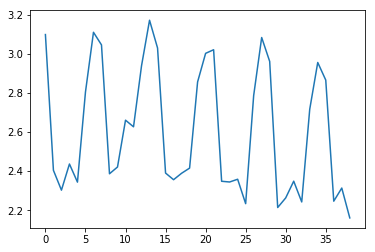

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.483117   
air_0164b9927d20bcc3_2017-04-23              1.755015   
air_0241aa3964b7f861_2017-04-23              2.419463   
air_0328696196e46f18_2017-04-23              2.047080   
air_034a3d5b40d5b1b1_2017-04-23              3.415416   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23  10.978542  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   4.783537  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.239824  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.745252  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  29.429621

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/3000eb_ridge_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')